<a href="https://colab.research.google.com/github/dauparas/tensorflow2_ipynb/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Import { display-mode: "form" }

from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

import tensorflow as tf
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()

import tensorflow_datasets as tfds
import tensorflow_probability as tfp


tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions
from keras.layers import Input, Embedding, LSTM, Dense

import pandas as pd
from scipy.sparse import csr_matrix
import umap
from sklearn.metrics.cluster import adjusted_rand_score

import h5py
#Step 1: import dependencies
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from __future__ import division
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import seaborn as sns; sns.set()
import keras.backend as K

import random

%matplotlib inline
plt.style.use('dark_background')

TensorFlow 2.x selected.


Using TensorFlow backend.


### Load Dataset

In [0]:
seed = 0
tf.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [0]:
X, Y = make_blobs(n_samples=1000, n_features=200, centers=10, cluster_std=2.0)
X = X.astype(np.float32)
Y = Y

In [4]:
print(X.shape, Y.shape)

(1000, 200) (1000,)


In [5]:
umap_emb = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='euclidean', random_state=seed).fit_transform(X);

/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 10 separate connected components using meta-embedding (experimental)
  n_components
/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


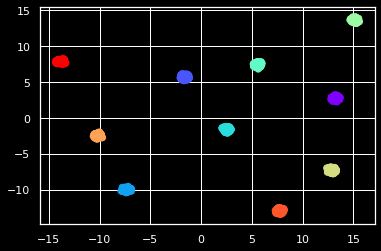

In [6]:
plt.scatter(umap_emb[:,0], umap_emb[:,1], c=Y, cmap='rainbow')

In [0]:
batch_size = 32
train_dataset = (X)
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.batch(batch_size)

# Create model

# Set prior

In [0]:
z_dim = 2
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(z_dim), scale=1),
                        reinterpreted_batch_ndims=1)

In [0]:
def make_x_given_z(input_shape, output_shape, act):
    model = tfk.Sequential([
    tfkl.InputLayer(input_shape=[input_shape]),
    tfkl.Dense(512, activation=act),
    tfkl.Dense(512, activation=act),
    tfkl.Dense(512, activation=act),
    tfkl.Dense(output_shape, activation=None),
    ])
    return model
  
def make_z_given_x(input_shape, output_shape, act):
    model = tfk.Sequential([
    tfkl.InputLayer(input_shape=[input_shape]),
    tfkl.Dense(512, activation=act),
    tfkl.Dense(512, activation=act),
    tfkl.Dense(512, activation=act),
    tfkl.Dense(2*output_shape),
    ])
    return model

In [0]:
z_given_x = make_z_given_x(X.shape[1], z_dim, tf.nn.leaky_relu)
x_given_z = make_x_given_z(z_dim, X.shape[1], tf.nn.leaky_relu)

In [0]:
optimizer = tf.keras.optimizers.Adam(3e-4)

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def test_step(X):

    with tf.GradientTape() as tape:
      z_mean_var = z_given_x(X, training=False)
      z_mean = z_mean_var[:,0:z_dim]
      z_log_var = z_mean_var[:,z_dim:]
      z_given_x_distr = tfd.Independent(tfd.Normal(loc=z_mean, scale=tf.nn.softplus(z_log_var)),reinterpreted_batch_ndims=1)
      z_sample = z_given_x_distr.sample()
      
      x = x_given_z(z_sample, training=False)      
      
      rec_loss = tf.reduce_mean(tf.square(X-x))
      kl_loss = tf.reduce_mean(tfd.kl_divergence(z_given_x_distr, prior))
                      
      loss = rec_loss + 1e-3*kl_loss

    gradients = tape.gradient(loss, z_given_x.trainable_variables + x_given_z.trainable_variables)

    optimizer.apply_gradients(zip(gradients, z_given_x.trainable_variables + x_given_z.trainable_variables))
    return rec_loss, kl_loss, loss, z_mean

In [0]:
def test(X, epoch):
      rec_loss, kl_loss, loss, z_mean = test_step(X)
      print ('epoch: {0:.1f}, rec_loss: {1:.3f}, kl_loss: {2:.3f}, loss: {3:.3f}'.format(epoch+1, rec_loss, kl_loss, loss))
      plt.figure(1)
      plt.figure(figsize=(6,4));
      plt.scatter(z_mean[:,0], z_mean[:,1], c=Y, cmap='rainbow')
      plt.title('Latent space representation')
      plt.xlabel('z1')
      plt.ylabel('z2')
      plt.show()
      return None

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(X):

    with tf.GradientTape() as tape:
      z_mean_var = z_given_x(X, training=True)
      z_mean = z_mean_var[:,0:z_dim]
      z_log_var = z_mean_var[:,z_dim:]
      z_given_x_distr = tfd.Independent(tfd.Normal(loc=z_mean, scale=tf.nn.softplus(z_log_var)),reinterpreted_batch_ndims=1)
      z_sample = z_given_x_distr.sample()
      
      x = x_given_z(z_sample, training=True)      
      
      rec_loss = tf.reduce_mean(tf.square(X-x))
      kl_loss = tf.reduce_mean(tfd.kl_divergence(z_given_x_distr, prior))
                      
      loss = rec_loss + 1e-3*kl_loss

    gradients = tape.gradient(loss, z_given_x.trainable_variables + x_given_z.trainable_variables)

    optimizer.apply_gradients(zip(gradients, z_given_x.trainable_variables + x_given_z.trainable_variables))
    return rec_loss, kl_loss, loss

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for X_batch in dataset:
      rec_loss, kl_loss, loss = train_step(X_batch)
    if ((epoch+1) % 50 == 0 or epoch==0):
       test(X, epoch) #run test on the whole dataset and visualise latent space
  return None

epoch: 1.0, rec_loss: 23.438, kl_loss: 628.659, loss: 24.066


<Figure size 432x288 with 0 Axes>

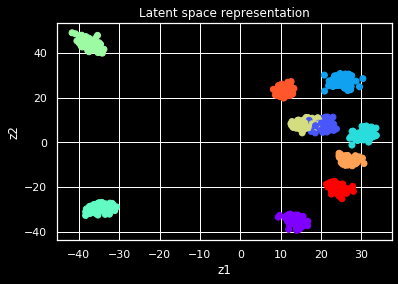

epoch: 50.0, rec_loss: 4.001, kl_loss: 61.682, loss: 4.062


<Figure size 432x288 with 0 Axes>

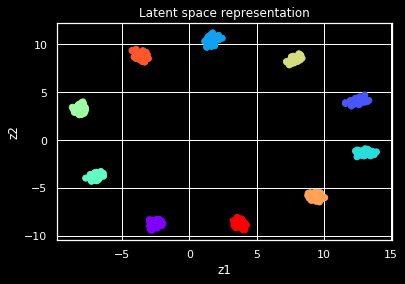

epoch: 100.0, rec_loss: 3.966, kl_loss: 31.664, loss: 3.997


<Figure size 432x288 with 0 Axes>

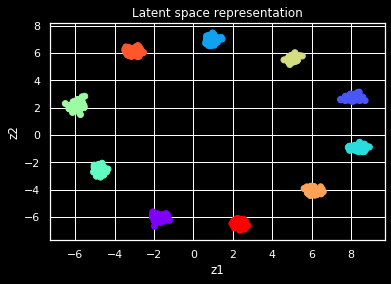

epoch: 150.0, rec_loss: 3.944, kl_loss: 22.540, loss: 3.966


<Figure size 432x288 with 0 Axes>

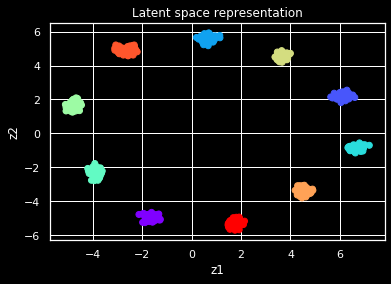

epoch: 200.0, rec_loss: 3.930, kl_loss: 18.957, loss: 3.949


<Figure size 432x288 with 0 Axes>

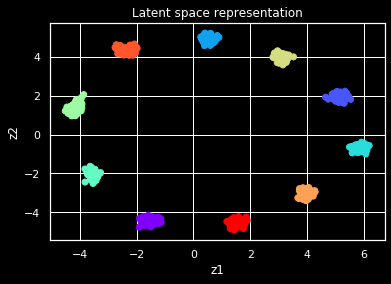

CPU times: user 18 s, sys: 1.2 s, total: 19.2 s
Wall time: 16.8 s


In [16]:
%%time
train(train_dataset, 200)